# Departamento de produção e manutenção

## Importação das bibliotecas

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2 # Carregar imagens
from skimage import io # Funções de pré-processamento de imagem
import tensorflow as tf
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import Dense, Input, AveragePooling2D, Flatten, Dropout, MaxPool2D
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, UpSampling2D, Concatenate
from tensorflow.keras.applications import ResNet50 # Criar o modelo de classificação
from tensorflow.keras.models import Model, load_model # Carregar o modelo e definir a rede neural
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint # Salvar os pesos da rede neural
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path_archives = '/content/drive/MyDrive/Ciência de Dados para Empresas e Negócios/Ciência de Dados para Empresas e Negócios/Departamento de manutenção/'

In [4]:
# Imagens das peças | URL e DEFEITUOSA (1) OU NÃO DEFEITUOSA (0)
all_images_df = pd.read_csv(path_archives+'defect_and_no_defect.csv')
all_images_df.shape

(12997, 2)

## Visualização e exploração dos dados

In [5]:
all_images_df.head()

,ImageID,label
0,0002cc93b.jpg,1
1,0007a71bf.jpg,1
2,000a4bcdd.jpg,1
3,000f6bf48.jpg,1
4,0014fce06.jpg,1


In [6]:
# Imagens com defeitos com a máscara
defect_class_mask_df = pd.read_csv(path_archives+'train.csv')
defect_class_mask_df.shape

(5748, 3)

In [7]:
defect_class_mask_df.head()

,ImageId,ClassId,EncodedPixels
0,d2291de5c.jpg,1,147963 3 148213 9 148461 18 148711 24 148965 2...
1,78416c3d0.jpg,3,54365 3 54621 7 54877 10 55133 12 55388 14 556...
2,2283f2183.jpg,3,201217 43 201473 128 201729 213 201985 5086 20...
3,f0dc068a8.jpg,3,159207 26 159412 77 159617 128 159822 179 1600...
4,00d639396.jpg,3,229356 17 229595 34 229850 36 230105 37 230360...


ClassId indica os tipos de defeitos (1, 2, 3, 4)

In [8]:
c_def, s_def = all_images_df['label'].value_counts()
print(f'{c_def} imagens com defeito\t{s_def} imagens sem defeito')

7095 imagens com defeito	5902 imagens sem defeito


Text(0.5, 1.0, 'Defeito e não defeito')

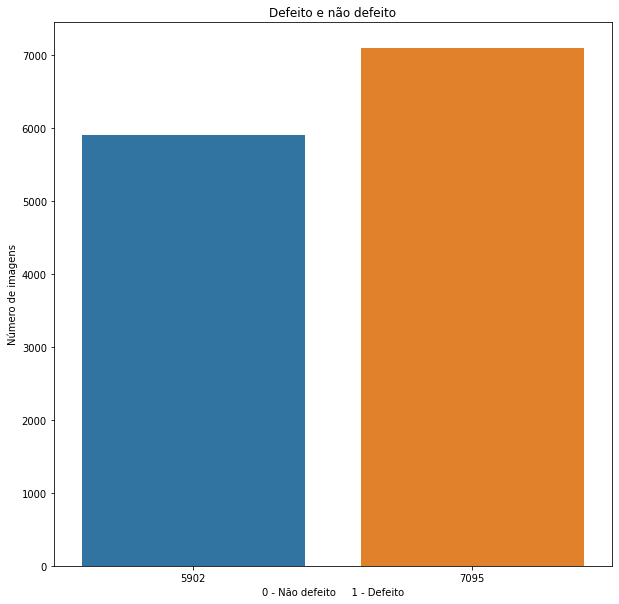

In [9]:
plt.figure(figsize = (10, 10))
sns.barplot(x = all_images_df['label'].value_counts(), y = all_images_df['label'].value_counts())
plt.ylabel('Número de imagens')
plt.xlabel('0 - Não defeito     1 - Defeito')
plt.title('Defeito e não defeito')

Visto que a classe de defeito [3] possui a maior frequência na base de dados, a classe de dados está desbalanceada.

Text(0.5, 1.0, 'Número de imagens por classe de defeito')

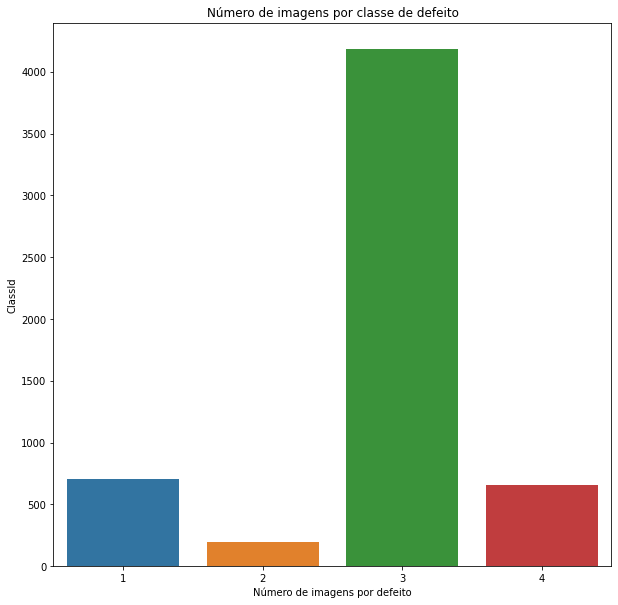

In [10]:
plt.figure(figsize = (10, 10))
sns.countplot(x = defect_class_mask_df['ClassId'])
plt.xlabel('Número de imagens por defeito')
plt.ylabel('ClassId')
plt.title('Número de imagens por classe de defeito')

Criando uma coluna que realiza a contagem de frequência de uma imagem, se a imagem tiver mais de um defeito, será visualaizado na contagem

In [11]:
defect_class_mask_df['mask'] = defect_class_mask_df['ClassId'].map(lambda x: 1)

In [12]:
# Group by das imagens por defeitos
defect_type = defect_class_mask_df.groupby(['ImageId'])['mask'].sum()
defect_type

ImageId
0002cc93b.jpg    1
0007a71bf.jpg    1
000a4bcdd.jpg    1
000f6bf48.jpg    1
0014fce06.jpg    1
                ..
ffcf72ecf.jpg    1
fff02e9c5.jpg    1
fffe98443.jpg    1
ffff4eaa8.jpg    1
ffffd67df.jpg    1
Name: mask, Length: 5474, dtype: int64

Text(0.5, 1.0, 'Número de defeitos nas imagens')

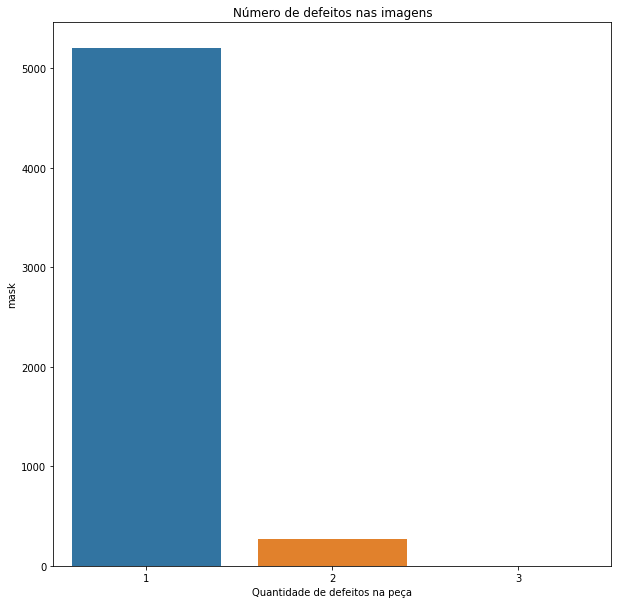

In [13]:
plt.figure(figsize=(10, 10))
sns.barplot(x = defect_type.value_counts().index, y = defect_type.value_counts())
plt.xlabel('Quantidade de defeitos na peça')
plt.title('Número de defeitos nas imagens')

Visualizando as imagens com defeitos

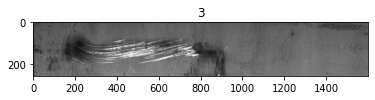

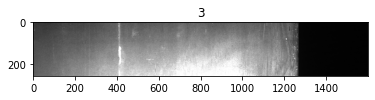

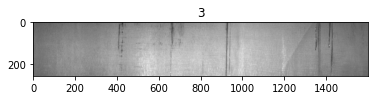

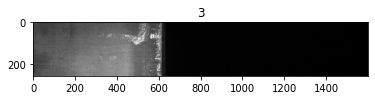

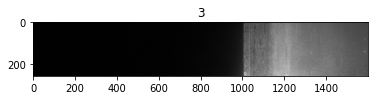

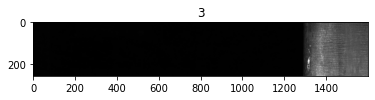

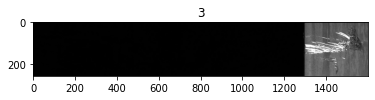

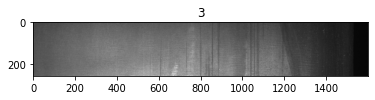

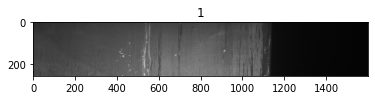

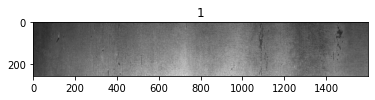

In [14]:
train_dir = path_archives + 'train_images/'
for i in range(63,73):
  img = io.imread(os.path.join(train_dir, defect_class_mask_df['ImageId'][i]))
  plt.figure()
  plt.title(defect_class_mask_df['ClassId'][i])
  plt.imshow(img)

In [15]:
count = len(defect_class_mask_df['EncodedPixels'][64])
print(f'A primeira imagem acima possui a dimensão de: {img.shape}, o que dá {img.shape[0] * img.shape[1] * img.shape[2]} pixels.\nCom o RLE, essa imagem ficou com {count} pixels.')

A primeira imagem acima possui a dimensão de: (256, 1600, 3), o que dá 1228800 pixels.
Com o RLE, essa imagem ficou com 257 pixels.


### Acessando arquivo py de utilitários
- **rle2mask**: converter do formato resumido para uma máscara completa
- **mas2rle**: convrter da máscara completa pro formato resumido

In [16]:
os.chdir(path_archives)

In [17]:
pwd

'/content/drive/.shortcut-targets-by-id/1LiZyvy49Ts4x2TyIp-UWJ2nxQ_0nfl5I/Ciência de Dados para Empresas e Negócios/Departamento de manutenção'

In [18]:
# Cria uma máscara das mesmas dimensões da imagem original, porém para poupar memória, é aplicado o RLE para reduzir a dimensionalidade da imagem
from utilities import rle2mask

In [19]:
image_index = 63
mask = rle2mask(defect_class_mask_df['EncodedPixels'][image_index], img.shape[0], img.shape[1])
mask.shape

(256, 1600)

Visualizar máscara e imagem original

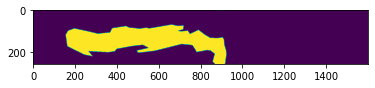

In [20]:
plt.imshow(mask)

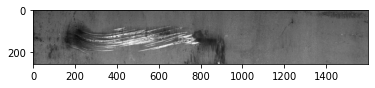

In [21]:
img = io.imread(os.path.join(train_dir, defect_class_mask_df['ImageId'][image_index]))
plt.imshow(img)

Visualizar mais imagens

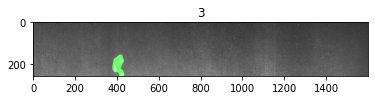

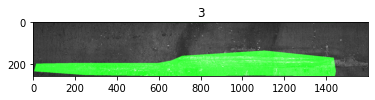

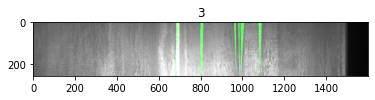

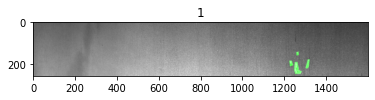

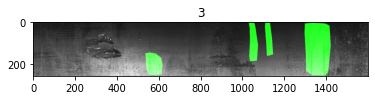

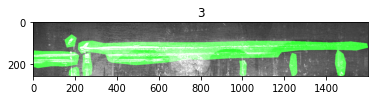

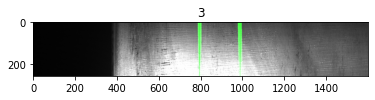

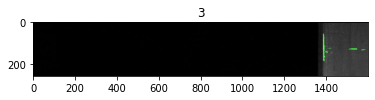

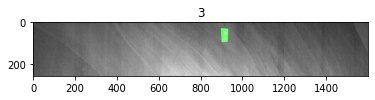

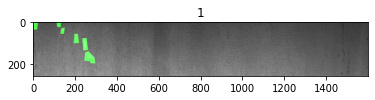

In [22]:
for i in range(1000, 1010):
  img = io.imread(os.path.join(train_dir, defect_class_mask_df['ImageId'][i])) # Imagem original
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # No CV2 o padrão de armazenamento é o BGR
  mask = rle2mask(defect_class_mask_df['EncodedPixels'][i], img.shape[0], img.shape[1]) # Imagem da mascara

  # Colorir os pixels
  img[mask == 1, 1] = 255 # Substituir o defeito por uma coloração diferente para visualizar a máscara
  plt.figure()
  plt.title(defect_class_mask_df['ClassId'][i])
  plt.imshow(img)

## Construção e treinamento da Resnet
**Nesta etapa, queremos identificar se a imagem possui ou não defeitos**

In [23]:
all_images_df

,ImageID,label
0,0002cc93b.jpg,1
1,0007a71bf.jpg,1
2,000a4bcdd.jpg,1
3,000f6bf48.jpg,1
4,0014fce06.jpg,1
...,...,...
12992,0482ee1d6.jpg,0
12993,04802a6c2.jpg,0
12994,03ae2bc91.jpg,0
12995,04238d7e3.jpg,0


### Separando base de treino, validação e teste

In [24]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(all_images_df, test_size = 0.15)
train.shape, test.shape

((11047, 2), (1950, 2))

Rescale: deixa as imagens na escala entre 0 e 1, importante fazer essa normalização principalmente quando se manipula redes neurais

In [25]:
from keras_preprocessing.image import ImageDataGenerator

In [26]:
datagen      = ImageDataGenerator(rescale=1./255, validation_split = 0.15)
test_datagen = ImageDataGenerator(rescale=1./255) 

flow_from_directory: Quando as imagens estão em pastas separadas (como por exemplo, o desafio do Depto Médico)  
flow_from_dataframe: Quando as imagens estão em um dataframe

In [27]:
# x_col      | Coluna que acessa as imagens na pasta
# y_col      | Coluna que contém as classes
# subset     | Definindo a base de dados (treinamento ) 
# batch_size | Número de imagens por batch
# class_mode | Se o problema é binário ou com multicategorias
# target_size | Tam da imagem (256, 256 é o padrão para o treinamento)

train_generator = datagen.flow_from_dataframe(train, directory=train_dir, x_col = 'ImageID', y_col = 'label', subset='training',
                                              batch_size = 16, shuffle = True,
                                              class_mode = 'other', target_size = (256, 256))

Found 9390 validated image filenames.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1 invalid image filename(s) in x_col="ImageID". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [28]:
valid_generator = datagen.flow_from_dataframe(train, directory=train_dir, x_col = 'ImageID', y_col = 'label', subset='validation',
                                              batch_size = 16, shuffle = True,
                                              class_mode = 'other', target_size = (256, 256))

Found 1656 validated image filenames.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1 invalid image filename(s) in x_col="ImageID". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [29]:
test_generator = test_datagen.flow_from_dataframe(test, directory = train_dir, x_col = 'ImageID', y_col = None,
                                                  batch_size = 16, shuffle = False,
                                                  class_mode = None, target_size = (256, 256))

Found 1950 validated image filenames.


In [30]:
#  INCLUDE_TOP = False não vamos utilizar porque já temos nosso problema personalizado (está com defeito ou não)
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape = (256, 256, 3)))

94781440/94765736 [==============================] - 2s 0us/step


In [31]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [32]:
# Congelar os pesos nas camadas
# Todos os pesos das camadas convolucionais vamos repassar para o nosso modelo, logo, as camadas convolucionais não podem ser treinadas
for layer in basemodel.layers:
  layers.trainable = False

### Criando camada densa personalizada

In [33]:
headmodel = basemodel.output                              # última saída da base anterior
headmodel = AveragePooling2D(pool_size=(4,4))(headmodel)  # pool_size | Tam da matriz para redução da dimensionalidade
headmodel = Flatten()(headmodel)                          # Transformar matriz em vetor
headmodel = Dense(256, activation = 'relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)                       # Retirar 30% dos neurônios, evita o overfitting
headmodel = Dense(1, activation = 'sigmoid')(headmodel)   # 1 neuronio pois temos problema de classificação binária

In [34]:
model = Model(inputs = basemodel.input, outputs = headmodel)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [35]:
# Compilar o modelo
model.compile(loss = 'binary_crossentropy', optimizer = 'Nadam', metrics = ['accuracy'])

O Early Stopping é utilizado para evitar o overfitting. Se após 20 epochs consecutivas o val_loss não diminuir, então o treinamento é parado.

In [36]:
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 20)

In [37]:
checkpointer = ModelCheckpoint(filepath='weights.hdf5', save_best_only = True) # save_best_only só é aplicado se existir uma base de dados de validação

In [38]:
# NÃO SERÁ TREINADO POIS DEMORA BASTANTE, VAMOS UTILIZAR O MODELO JÁ FORNECIDO PELA AULA
# history = model.fit(train_generator, epochs = 40,
#                               validation_data = valid_generator,
#                               callbacks = [checkpointer, earlystopping])

Salvar estrutura da rede neural

In [39]:
# model_json = model.to_json()
# with open('resnet-classifier-model.json', 'w') as json_file:
#   json_file.write(model_json)

# Avaliação da Resnet

Toda a estrutura da Resnet junto com a parte personalizada que fizemos

In [41]:
with open('resnet-classifier-model.json', 'r') as json_file:
  json_saved_model = json_file.read()
json_saved_model

'{"class_name": "Functional", "config": {"name": "functional_1", "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 256, 256, 3], "dtype": "float32", "sparse": false, "ragged": false, "name": "input_1"}, "name": "input_1", "inbound_nodes": []}, {"class_name": "ZeroPadding2D", "config": {"name": "conv1_pad", "trainable": true, "dtype": "float32", "padding": [[3, 3], [3, 3]], "data_format": "channels_last"}, "name": "conv1_pad", "inbound_nodes": [[["input_1", 0, 0, {}]]]}, {"class_name": "Conv2D", "config": {"name": "conv1_conv", "trainable": true, "dtype": "float32", "filters": 64, "kernel_size": [7, 7], "strides": [2, 2], "padding": "valid", "data_format": "channels_last", "dilation_rate": [1, 1], "groups": 1, "activation": "linear", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regula

Carregar os pesos da rede neural

In [43]:
# Criando uma rede neural com a mesma estrutura criada anteriormente
model = tf.keras.models.model_from_json(json_saved_model)
# Carregando os pesos
model.load_weights('weights.hdf5') # Se tiver feito o treinamento não é necessário fazer essa etapa
# Vamos compilar o modelo para passar a base de dados de teste
model.compile(loss = 'binary_crossentropy', optimizer= 'Nadam', metrics = ['accuracy'])

In [44]:
# Por estar dividido em batches de 16, terá 122 batches de 16 imagens
test_predict = model.predict(test_generator, verbose = True)

122/122 [==============================] - 939s 8s/step


A função **sigmoid** gera valores de probabilidade entre 0 e 1  
Em geral, definimos um linear de 0.5, ou seja, se predict < 0.5, então a classe é = 0, se não a classe é =1.  
Como queremos ter um grau de certeza maior de que a imagem está com defeito, vamos definir o linear de 99% para as peças serem consideradas defeituosas.

In [114]:
predict = list()
for i in test_predict:
  if i < 0.01:
    predict.append(0)
  else:
    predict.append(1)

predict = np.asarray(predict)
len(predict), predict

(1950, array([1, 1, 1, ..., 0, 1, 1]))

In [115]:
original = np.asarray(test.label)
len(original), original

(1950, array([1, 1, 1, ..., 0, 1, 1]))

In [116]:
np.set_printoptions(suppress=True)
test_predict = np.asarray(test_predict)
percent = lambda x: x*100
vfunc = np.vectorize(percent)

vfunc(test_predict)

array([[99.99992847],
       [99.97543097],
       [99.51277971],
       ...,
       [ 0.        ],
       [99.99876022],
       [51.45725012]])

In [117]:
x = np.array([1, 2, 3, 4, 5])
squarer = lambda t: t ** 2
vfunc = np.vectorize(squarer)
vfunc(x)

array([ 1,  4,  9, 16, 25])

Verificar a acurácia das predições

In [122]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [119]:
acc = accuracy_score(original, predict)
print(f'Temos uma acurácia de {round(acc*100, 2)}% das predições realizadas')

Temos uma acurácia de 89.28% das predições realizadas


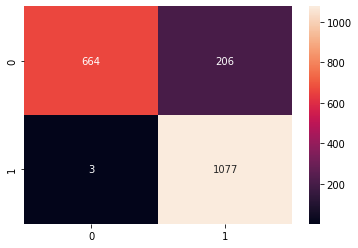

In [120]:
cm = confusion_matrix(original, predict)
sns.heatmap(cm, annot=True, fmt='g')

In [123]:
print(classification_report(original, predict))

              precision    recall  f1-score   support

           0       1.00      0.76      0.86       870
           1       0.84      1.00      0.91      1080

    accuracy                           0.89      1950
   macro avg       0.92      0.88      0.89      1950
weighted avg       0.91      0.89      0.89      1950

